In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 📚 Importing Libraries

In [34]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc, RocCurveDisplay, PrecisionRecallDisplay
import xgboost as xgb

shap.initjs()

## 📥 Load Data

In this step, we load the **German Credit Dataset**, a popular benchmark dataset used for evaluating credit risk prediction models. Each row in the dataset represents a loan applicant, with various attributes related to their credit history, financial situation, and personal information.

The dataset includes features such as:

- **duration** – Duration of the credit in months  
- **amount** – Loan amount requested  
- **purpose** – Reason for the loan (e.g., car, education, etc.)  
- **employment_duration** – Employment duration  
- **personal_status_sex**, **housing**, etc. – Categorical attributes encoded as separate columns

---

### 🎯 Target Variable: `credit_risk`

The target variable in this dataset is `credit_risk`, which represents the **credit risk** associated with a loan applicant.

After preprocessing, the values are encoded as:

| Label (Original) | Encoded Value | Description |
|------------------|---------------|-------------|
| **Good**         | `0`           | Applicant is a **good credit risk** (likely to repay the loan) |
| **Bad**          | `1`           | Applicant is a **bad credit risk** (likely to default on the loan) |

We treat this as a binary classification problem, where:
- `0` → No default risk (Safe borrower)
- `1` → High default risk (Risky borrower)

This encoding enables machine learning models to distinguish between reliable and risky applicants during training.

In [78]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/GermanCredit.csv")
df.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,present_residence,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,... < 100 DM,6,critical account/other credits existing,domestic appliances,1169,unknown/no savings account,... >= 7 years,4,male : single,none,4,real estate,67,none,own,2,skilled employee/official,1,yes,yes,1
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,none,2,real estate,22,none,own,1,skilled employee/official,1,no,yes,0
2,no checking account,12,critical account/other credits existing,retraining,2096,... < 100 DM,4 <= ... < 7 years,2,male : single,none,3,real estate,49,none,own,1,unskilled - resident,2,no,yes,1
3,... < 100 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,guarantor,4,building society savings agreement/life insurance,45,none,for free,1,skilled employee/official,2,no,yes,1
4,... < 100 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,none,4,unknown/no property,53,none,for free,2,skilled employee/official,2,no,yes,0


In [79]:
feature_names = df.columns.to_list()
print("Feature Names :")
for feature in feature_names:
    print("-", feature)

Feature Names :
- status
- duration
- credit_history
- purpose
- amount
- savings
- employment_duration
- installment_rate
- personal_status_sex
- other_debtors
- present_residence
- property
- age
- other_installment_plans
- housing
- number_credits
- job
- people_liable
- telephone
- foreign_worker
- credit_risk


In [80]:
df['personal_status_sex'].unique()

array(['male : single', 'female : divorced/separated/married',
       'male : divorced/separated', 'male : married/widowed'],
      dtype=object)

In [81]:
df['gender'] = df['personal_status_sex'].apply(lambda x: 0 if 'female' in x else 1) #male=1, female=0
df.drop(columns='personal_status_sex', inplace=True)

In [82]:
df.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,other_debtors,present_residence,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk,gender
0,... < 100 DM,6,critical account/other credits existing,domestic appliances,1169,unknown/no savings account,... >= 7 years,4,none,4,real estate,67,none,own,2,skilled employee/official,1,yes,yes,1,1
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,none,2,real estate,22,none,own,1,skilled employee/official,1,no,yes,0,0
2,no checking account,12,critical account/other credits existing,retraining,2096,... < 100 DM,4 <= ... < 7 years,2,none,3,real estate,49,none,own,1,unskilled - resident,2,no,yes,1,1
3,... < 100 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,guarantor,4,building society savings agreement/life insurance,45,none,for free,1,skilled employee/official,2,no,yes,1,1
4,... < 100 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,none,4,unknown/no property,53,none,for free,2,skilled employee/official,2,no,yes,0,1


## ⚙️ Data Preprocessing

Before training our models, we need to preprocess the data to make it suitable for machine learning algorithms.

### 🧠 1. Split Features and Target

We separate the features (`X`) from the target (`y`), so we can train supervised models.

### 🔤 2. Encode Categorical Features

We apply **one-hot encoding** using `pandas.get_dummies()` to convert categorical variables into numeric format that machine learning models can understand.
- `drop_first=True` is used to avoid multicollinearity.

### 🔀 3. Train-Test Split

We split the dataset into **training** and **test** sets using `train_test_split`:
- `test_size=0.2`: 80% training, 20% testing
- `stratify=y`: ensures class balance across splits
- `random_state=42`: for reproducibility

---

### ⚖️ 4. Do We Need to Scale?

Scaling is **not required** for **tree-based models** like:
- XGBoost
- LightGBM
- Decision Trees
- Random Forests

These models **split data based on feature thresholds** and are **not affected by the scale** of the features.

In [83]:
y = df['credit_risk']
X = df.drop(columns=['credit_risk'])

# Label encode categoricals
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42)


## 🚀 Model Training: XGBoost Classifier

We use the **XGBoost Classifier**, a highly efficient and scalable gradient boosting framework, to train our binary classification model.

### 📘 Key Concepts:

- **XGBoost (Extreme Gradient Boosting)** is widely used in industry and competitions for structured data tasks due to its accuracy, speed, and flexibility.

### 🔧 Model Parameters Used:

- **`use_label_encoder=False`**  
  Disables the legacy label encoder to avoid unnecessary warnings.

- **`eval_metric='logloss'`**  
  Logarithmic loss is suitable for binary classification tasks. It penalizes incorrect predictions with increasing confidence.

- **`random_state=42`**  
  Ensures reproducibility by controlling random behavior during training.

- **`n_estimators=200`**  
  Specifies the number of boosting rounds (trees). More estimators can improve performance but may also increase training time or overfit.

- **`max_depth=4`**  
  Limits how deep each decision tree can grow. Shallower trees reduce model complexity and help generalize better.

- **`learning_rate=0.1`**  
  Controls how much each tree contributes to the final prediction. Smaller values lead to slower but potentially more accurate learning.

### 🎯 Goal:

The model learns to distinguish between **'Good'** and **'Bad'** credit risk customers using the training data, aiming to minimize classification errors and maximize generalization on unseen data.

In [84]:
clf_xgb = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1
)

#XGBoost internally uses DMatrix, which relies on clean, valid feature names. If it encounters special characters like [ or <, it throws this error to avoid parsing issues or injection vulnerabilities.
X_train.columns = X_train.columns.str.replace(r"[\[\]<>]", "_", regex=True)
X_test.columns = X_test.columns.str.replace(r"[\[\]<>]", "_", regex=True)

clf_xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## 📊 Model Evaluation

In [85]:
y_pred = clf_xgb.predict(X_test)
y_probs = clf_xgb.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.50      0.52        60
           1       0.79      0.82      0.81       140

    accuracy                           0.73       200
   macro avg       0.67      0.66      0.66       200
weighted avg       0.72      0.72      0.72       200



In [86]:
roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 0.7477


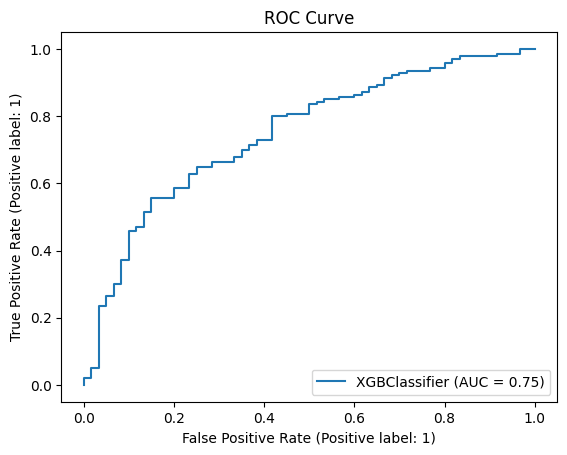

In [87]:
RocCurveDisplay.from_estimator(clf_xgb, X_test, y_test)
plt.title("ROC Curve")
plt.show()

Precision-Recall AUC: 0.8562


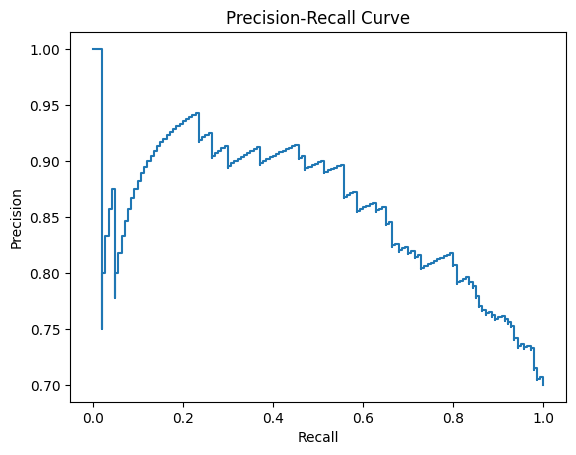

In [88]:
precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc:.4f}")

PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.title("Precision-Recall Curve")
plt.show()


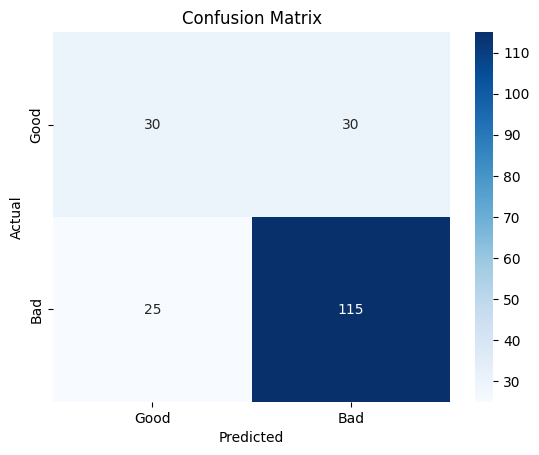

In [89]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## 🔍 SHAP Explainer for Model Interpretability

SHAP (SHapley Additive exPlanations) is a game-theoretic approach to explain the output of machine learning models. It assigns each feature an importance value for a particular prediction, helping us understand **why** a model made a certain decision.

### 💡 Why Use SHAP?
- Provides both **global** and **local** interpretability.
- Works well with tree-based models like XGBoost.
- Shows **feature importance**, **interaction effects**, and **individual prediction contributions**.

### 🧠 Key Components
- `shap.Explainer`: Initializes the SHAP explainer with our trained model.
- `shap_values = explainer(X_test)`: Calculates SHAP values for the test data.

### 📊 Visualizations

- **Bar Summary Plot**: Shows the most important features globally, ranked by their mean absolute SHAP value.
- **Dot Summary Plot**: Reveals both importance and effect direction (positive or negative impact on prediction).
- **Waterfall Plot**: Explains a single prediction by showing how each feature pushes the output from the base value.
- **Interaction Scatter Plot**: Visualizes how two features interact and affect the prediction.

SHAP is a powerful tool for building trust and transparency in machine learning models, especially when model predictions impact real-world decisions.

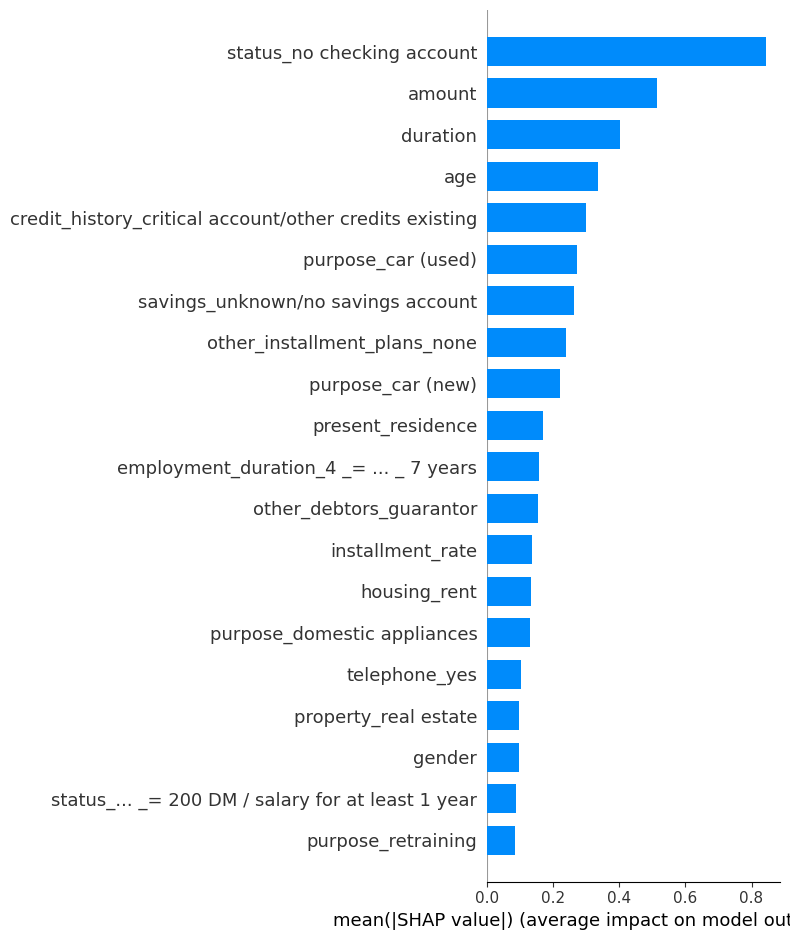

In [90]:
explainer = shap.Explainer(clf_xgb)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

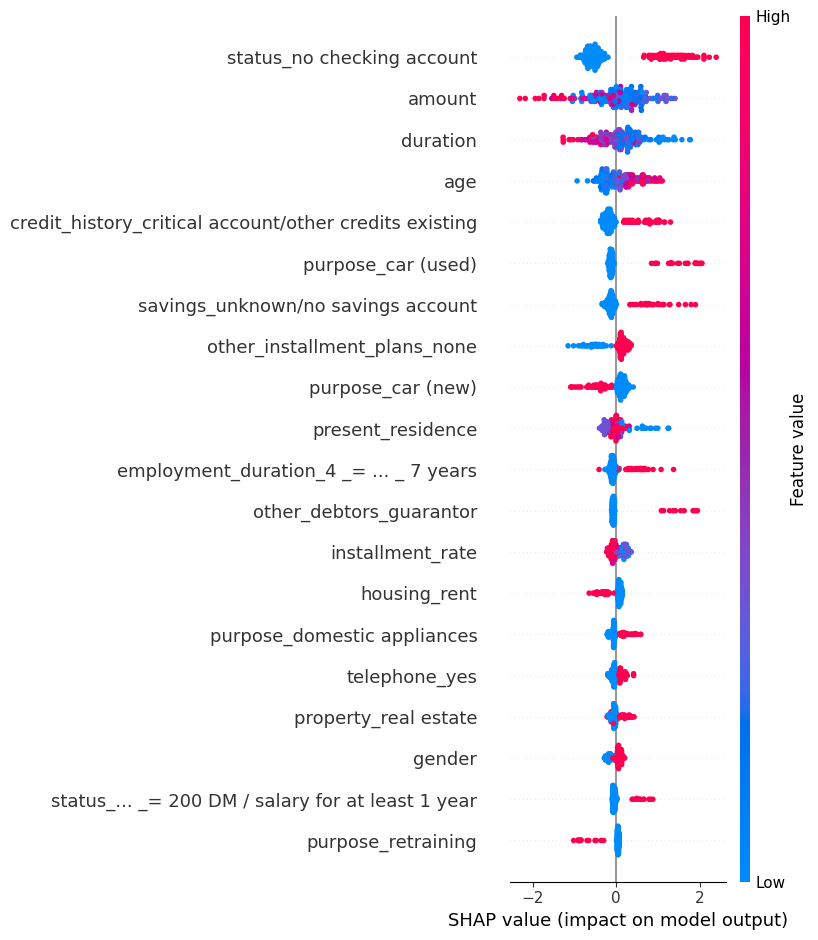

In [91]:
shap.summary_plot(shap_values, X_test)

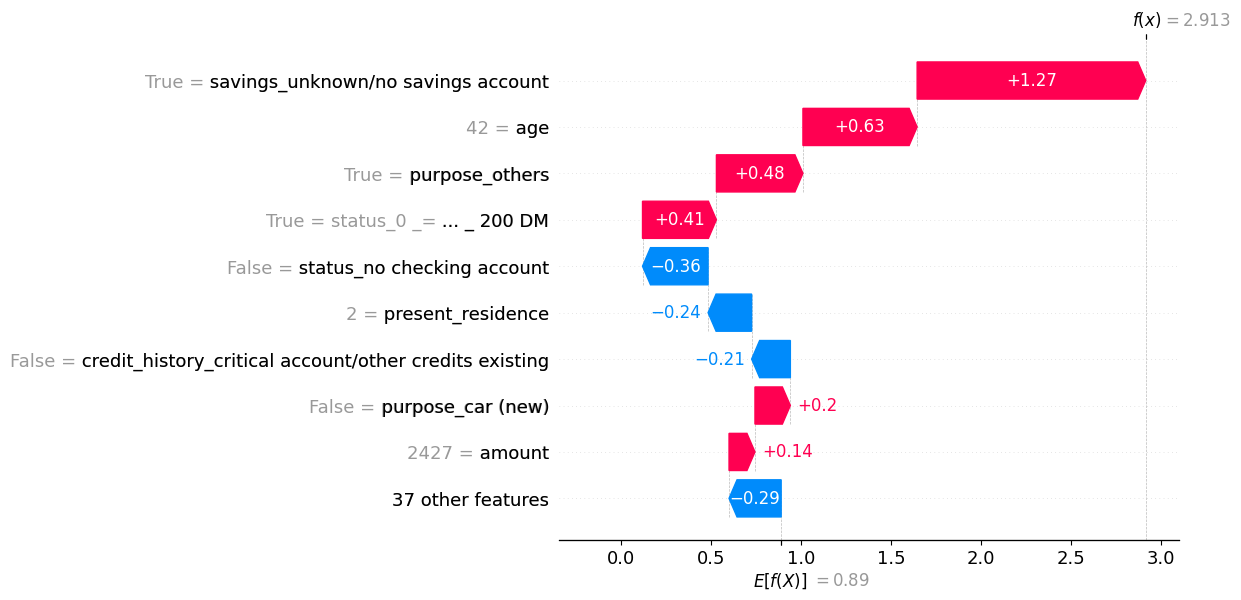

In [92]:
#Waterfall plot for single prediction (first test sample)
shap.plots.waterfall(shap_values[0])

The figure layout has changed to tight
The figure layout has changed to tight


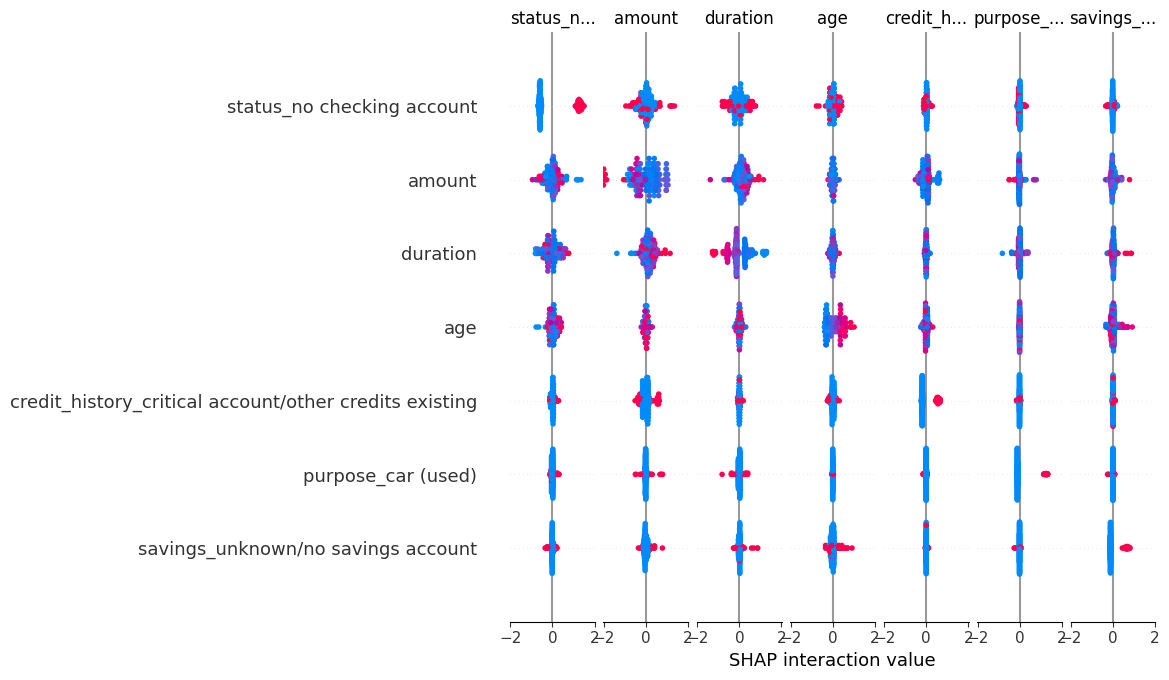

In [93]:
#Interaction Effects

interaction_values = shap.TreeExplainer(clf_xgb).shap_interaction_values(X_test)

# Visualize most important interaction
shap.summary_plot(interaction_values, X_test)

## ⚖️ Counterfactual Fairness Check

**Counterfactual fairness** assesses whether a model's prediction would change if a sensitive attribute (e.g., gender, race, age) were altered, while keeping all other features constant.

### 🎯 Objective

Ensure that the model's decisions are **not unfairly influenced** by protected attributes. A fair model should give consistent outputs even when sensitive features are changed.

### 🔍 How It Works

To perform a counterfactual fairness check:

1. **Select a sensitive feature**, such as `Gender`.
2. **Create counterfactual samples** by modifying only the sensitive feature (e.g., change male to female), while keeping all other feature values the same.
3. **Compare model predictions** between the original and counterfactual samples.
4. **Measure fairness** by analyzing how much the predictions differ.

### 📈 Fairness Metric

You can quantify fairness using metrics like:

- **Counterfactual Discrepancy**:  
  $$ \text{CFD} = \frac{1}{N} \sum_{i=1}^{N} |f(x_i) - f(x_i^{cf})| $$
  where $begin:math:text$ x_i^{cf} $end:math:text$ is the counterfactual version of $begin:math:text$ x_i $end:math:text$.

- **Percentage Changed**:  
  The percentage of predictions that change due to modification in the sensitive feature.

### 🧪 Example

For example, if changing the `Gender` from "Male" to "Female" (or vice versa) results in significantly different model predictions for credit approval, the model may exhibit **gender bias**.

### ✅ Goal

A model is considered counterfactually fair if:
- Minimal or no change in prediction occurs when only sensitive features are altered.
- The sensitive attribute does **not unjustifiably influence** outcomes.

Ensuring counterfactual fairness improves model **trustworthiness**, **ethical soundness**, and **compliance** with AI fairness standards.

In [94]:
feature_list = X_test.columns.to_list()
for feature in feature_list:
    print("-", feature)

- duration
- amount
- installment_rate
- present_residence
- age
- number_credits
- people_liable
- gender
- status_... _= 200 DM / salary for at least 1 year
- status_0 _= ... _ 200 DM
- status_no checking account
- credit_history_critical account/other credits existing
- credit_history_delay in paying off in the past
- credit_history_existing credits paid back duly till now
- credit_history_no credits taken/all credits paid back duly
- purpose_car (new)
- purpose_car (used)
- purpose_domestic appliances
- purpose_education
- purpose_furniture/equipment
- purpose_others
- purpose_radio/television
- purpose_repairs
- purpose_retraining
- savings_... _= 1000 DM
- savings_100 _= ... _ 500 DM
- savings_500 _= ... _ 1000 DM
- savings_unknown/no savings account
- employment_duration_... _= 7 years
- employment_duration_1 _= ... _ 4 years
- employment_duration_4 _= ... _ 7 years
- employment_duration_unemployed
- other_debtors_guarantor
- other_debtors_none
- property_car or other
- property

In [95]:
X_test['gender'].unique()

array([1, 0])

In [96]:
sensitive_feature = 'gender'

test_flipped = X_test.copy()
test_flipped[sensitive_feature] = 1 - test_flipped[sensitive_feature]

shap_values_flipped = explainer(test_flipped)

shap_diff = shap_values.values - shap_values_flipped.values

mean_abs_diff_per_sample = np.abs(shap_diff).mean(axis=1)

print(f"Average SHAP value change after flipping '{sensitive_feature}': {np.mean(mean_abs_diff_per_sample):.4f}")

Average SHAP value change after flipping 'gender': 0.0130


In [98]:
probs_original = clf_xgb.predict_proba(X_test)[:, 1]
probs_flipped = clf_xgb.predict_proba(test_flipped)[:, 1]
prob_diff = np.abs(probs_original - probs_flipped)
print(f"Average change in predicted probabilities after flipping '{sensitive_feature}': {np.mean(prob_diff):.4f}")

Average change in predicted probabilities after flipping 'gender': 0.0349


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


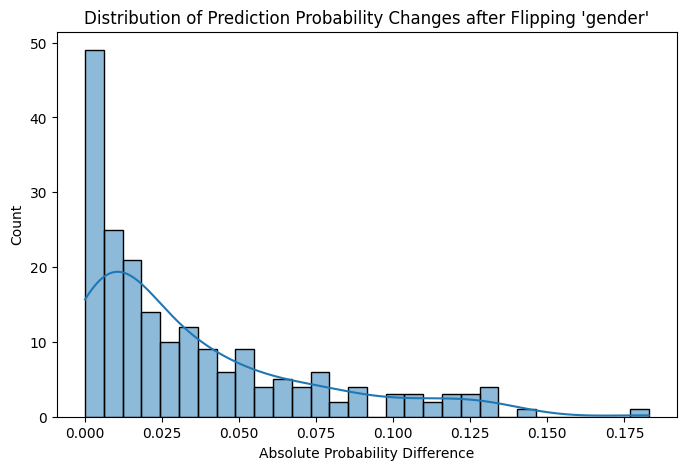

In [99]:
plt.figure(figsize=(8,5))
sns.histplot(prob_diff, bins=30, kde=True)
plt.title(f"Distribution of Prediction Probability Changes after Flipping '{sensitive_feature}'")
plt.xlabel("Absolute Probability Difference")
plt.show()

### Counterfactual Fairness Check Conclusion

Clearly, from the above analysis, we can see that there is no gender-based bias in credit approval decisions. The average change in SHAP values after flipping the `gender` feature was minimal, indicating that the model's predictions are not significantly influenced by gender. This suggests that the model exhibits counterfactual fairness with respect to gender.

### 📊 Calibration Curve (Reliability Diagram)

The **calibration curve**, also known as the **reliability diagram**, is a powerful diagnostic tool to evaluate how well a model's predicted probabilities reflect the actual outcomes. It compares the predicted probability of a positive outcome with the observed frequency of that outcome.

In the plot:
- The **diagonal line** represents a perfectly calibrated model.
- The **model curve** shows how the predicted probabilities from our XGBoost model align with actual outcomes.

A curve close to the diagonal indicates good calibration. If the curve lies below the diagonal, the model is **overconfident** (predicts probabilities that are too high). If it lies above, it is **underconfident** (predicts probabilities that are too low).

This analysis is crucial when model outputs are used to inform decisions, especially in high-stakes domains like finance and healthcare.

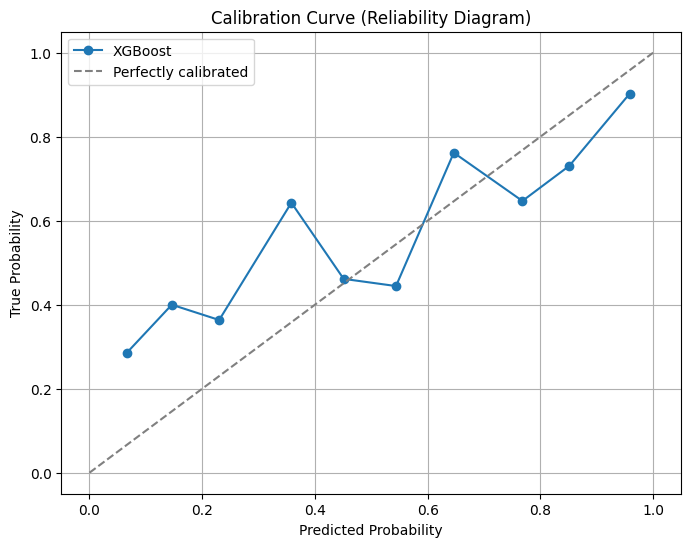

In [101]:
from sklearn.calibration import calibration_curve

y_proba = clf_xgb.predict_proba(X_test)[:, 1]

prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy='uniform')

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='XGBoost')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.title('Calibration Curve (Reliability Diagram)')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend()
plt.grid(True)
plt.show()